In [1]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import graph_tool.all as gt



src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir, 'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.shift_graph_maker as sgm

In [2]:
# from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
with open('/home/projects/movie-network/data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [6]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [7]:
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year', 'genres']]

In [8]:
movie_producer_df = movie_producer_df.sort_values('year')

In [9]:
movie_producer_df.head()

,_id,producers,producing_gender_percentage,title,year,genres
22884,tt0099622,"[[nm0000339, producer], [nm0515891, producer],...",33.333333,Full Fathom Five,1990,"[Action, Adventure]"
22502,tt0100822,"[[nm0135847, executive producer], [nm0275836, ...",0.000000,Tune in Tomorrow...,1990,"[Comedy, Romance]"
10973,tt0100935,"[[nm0326512, producer], [nm0474138, executive ...",0.000000,Wild at Heart,1990,"[Comedy, Crime, Drama, Thriller]"
22559,tt0099819,"[[nm0342045, executive producer], [nm0270288, ...",20.000000,I Love You to Death,1990,"[Comedy, Crime]"
24509,tt0099796,"[[nm0321860, line producer], [nm0711910, produ...",50.000000,Horseplayer,1990,"[Drama, Thriller]"


## Community detecton using graph_tool

In [10]:
movie_producer_df = movie_producer_df.set_index('_id')
movie_producer_dict = movie_producer_df.to_dict(orient='index')

In [11]:
movie_producer_dict['tt0099622']

{'producers': [['nm0000339', 'producer'],
  ['nm0515891', 'producer'],
  ['nm0560370', 'associate producer']],
 'producing_gender_percentage': 33.333333333333336,
 'title': 'Full Fathom Five',
 'year': 1990,
 'genres': ['Action', 'Adventure']}

### Make graph

## Stochastic block model

In [12]:
g = sgm.make_graph(movie_producer_dict)

In [13]:
clabel = g.vp['kind']
state = gt.minimize_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel})

In [14]:
state

<BlockState object with 4 blocks (4 nonempty), degree-corrected, for graph <Graph object, undirected, with 7767 vertices and 10704 edges at 0x7f6653720470>, at 0x7f66537006d8>

In [15]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)

In [16]:
state.get_bs

<bound method NestedBlockState.get_bs of <NestedBlockState object, with base <BlockState object with 2 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 7767 vertices and 10704 edges at 0x7f6653720470>, at 0x7f66536c89e8>, and 2 levels of sizes [(7767, 2), (2, 1)] at 0x7f66536dcbe0>>

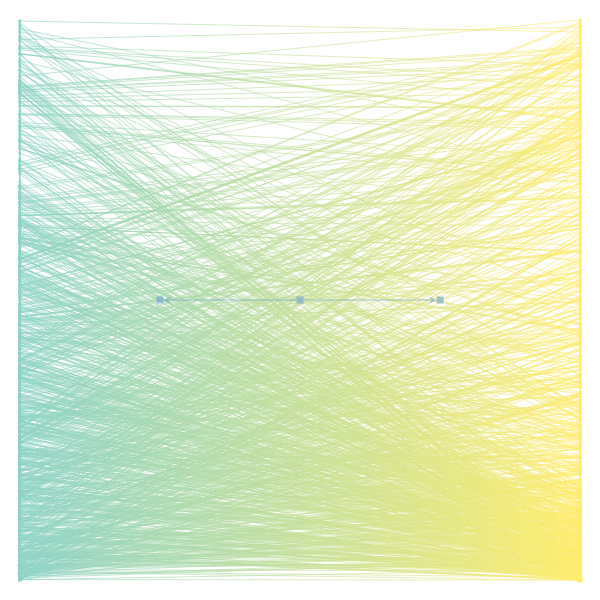

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6653720470, at 0x7f66536dc0b8>,
 <Graph object, directed, with 7770 vertices and 7769 edges at 0x7f66537355f8>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f66537355f8, at 0x7f66536dc4a8>)

In [17]:
gt.draw_hierarchy(state,layout='bipartite',\
              output=None,\
              subsample_edges=1000,\
              hshortcuts=1, hide=0,\
              )

In [18]:
component = gt.label_largest_component(g)

sum(np.array(component.a))

6279

## giant component community

In [ ]:
# g = make_graph(movie_producer_dict)
# del_list = []
# for v in g.vertices():
#     c = component[v]
#     if c == 0:
#         del_list.append(v)

In [ ]:
# for v in reversed(sorted(del_list)):
#     g.remove_vertex(v)

In [ ]:
# state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)
# state

In [ ]:
# gt.draw_hierarchy(state,layout='bipartite',\
#               output=None,\
#               subsample_edges=1000,\
#               hshortcuts=1, hide=0,\
#               )

## remove nodes with one edge

In [19]:
g = sgm.make_graph(movie_producer_dict)

In [20]:
one_degree_nodes = []
for v in g.vertices():
    edge_num = len(g.get_out_edges(v))
    if edge_num == 1:
        one_degree_nodes.append(v)

In [21]:
for v in reversed(sorted(one_degree_nodes)):
    g.remove_vertex(v)

In [22]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)
state.entropy()

47984.80372382357

In [23]:
g.num_vertices()

3769

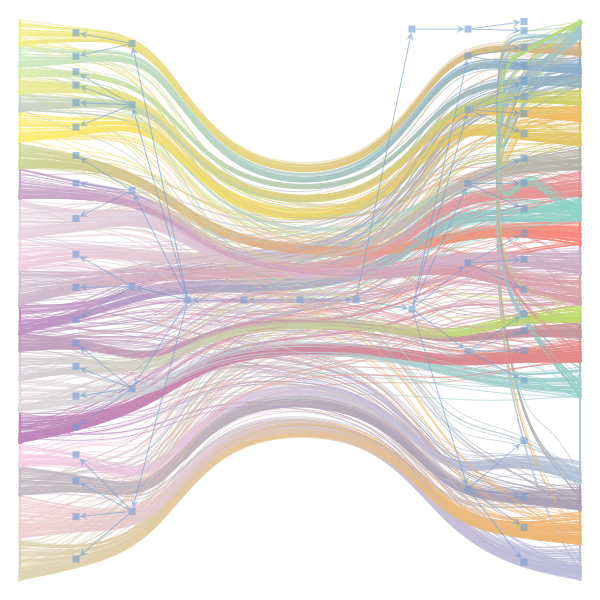

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f66c9da26a0, at 0x7f66536c8f60>,
 <Graph object, directed, with 3830 vertices and 3829 edges at 0x7f6653749320>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6653749320, at 0x7f6653679fd0>)

In [24]:
gt.draw_hierarchy(state,layout='bipartite',\
              output=None,\
              subsample_edges=1500,\
              hshortcuts=1, hide=0,\
              beta=0.5
              )

In [25]:
state.entropy(), block_state.entropy()

NameError: name 'block_state' is not defined

In [ ]:
block_state = gt.minimize_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)


In [ ]:
block_state

In [ ]:
b = block_state.b
print(np.unique(np.array(b.a)))
i = 0
for v in g.vertices():
    print (g.vp['name'][v])
    print(b[v])
    i += 1
    if i == 100:
        break